# Banxico SIE indexes

@roman

28 June, 2024


Minimum wage and INPC indexes will be joined to the general dataset.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns

from INEGIpy import Indicadores
from sie_banxico import SIEBanxico

from datetime import datetime
from dotenv import load_dotenv


In [2]:
# load environment variables
load_dotenv()

# inegi class
inegi_api = Indicadores(token=os.getenv('API_INEGI'))

---
# INPC

## Data

In [3]:
# get inpc
df_inpc, metadatos = inegi_api.obtener_df(
    indicadores='583731',
    metadatos=True,
    inicio='2016-01-01'
)
df_inpc, inegi_api.consulta_metadatos(metadatos)

/Users/ravj/opt/anaconda3/envs/mds-research-stay/lib/python3.10/site-packages/INEGIpy/_indicadores.py:108: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.set_index(pd.to_datetime(df.fechas),inplace=True, drop=True)


(                583731
 fechas                
 2016-01-01   89.386381
 2016-02-01   89.777781
 2016-03-01   89.910001
 2016-04-01   89.625278
 2016-05-01   89.225615
 ...                ...
 2024-01-01  133.555000
 2024-02-01  133.681000
 2024-03-01  134.065000
 2024-04-01  134.336000
 2024-05-01  134.087000
 
 [101 rows x 1 columns],
                                                       583731
 INDICADOR                       Precios al Consumidor (INPC)
 FREQ                                                 Mensual
 TOPIC                           Precios al Consumidor (INPC)
 UNIT        Índice base segunda quincena de julio 2018 = 100
 UNIT_MULT                                               None
 NOTE                                                        
 SOURCE                            INEGI. Índices de precios.
 LASTUPDATE                         07/06/2024 12:10:11 p. m.
 STATUS                                                  None
 BANCO                                   

## Wrangling

In [4]:
# diferentiate the series
df_inpc = (
    df_inpc
    # rename
    .rename(columns={'583731': 'inpc'})
    .rename_axis('date')
    # assign values
    .assign(
        pct_change_inpc=lambda x: x['inpc'].pct_change(),
        # rolling avg of pct_change of last 6 months
        rolling_avg_pct_change_inpc=lambda x: x['pct_change_inpc'].rolling(6).mean(),
        # exponential moving avg of pct_change of last 6 months
        em_avg_pct_change_inpc=lambda x: x['pct_change_inpc'].ewm(span=6, adjust=False).mean()
    )
)
df_inpc

,inpc,pct_change_inpc,rolling_avg_pct_change_inpc,em_avg_pct_change_inpc
date,,,,
2016-01-01,89.386381,NaN,NaN,NaN
2016-02-01,89.777781,0.004379,NaN,0.004379
2016-03-01,89.910001,0.001473,NaN,0.003548
2016-04-01,89.625278,-0.003167,NaN,0.001630
2016-05-01,89.225615,-0.004459,NaN,-0.000110
...,...,...,...,...
2024-01-01,133.555000,0.008929,0.006020,0.006275
2024-02-01,133.681000,0.000943,0.005255,0.004752
2024-03-01,134.065000,0.002873,0.004994,0.004215


## EDA

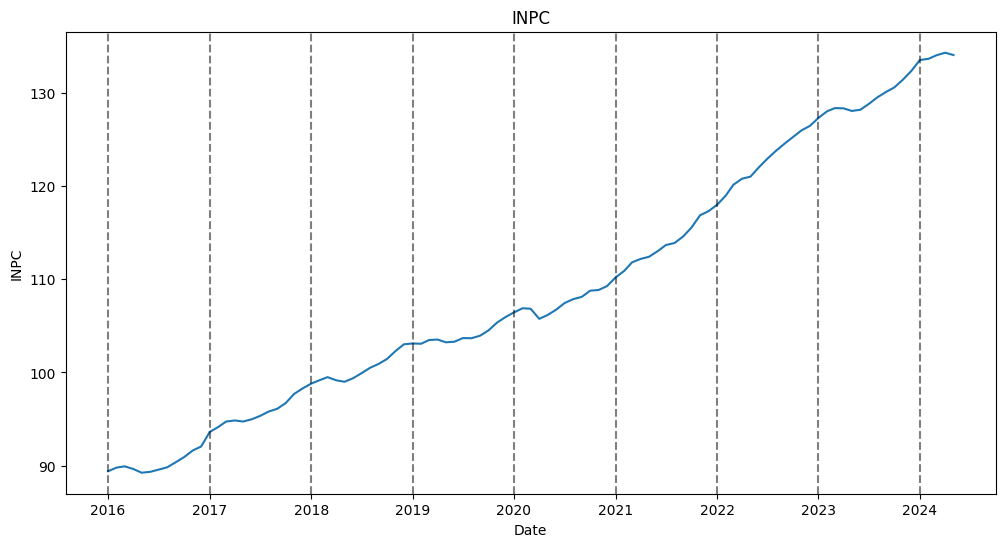

In [5]:
# see trend
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_inpc, x='date', y='inpc')
# titles
plt.title('INPC')
# labels
plt.xlabel('Date')
plt.ylabel('INPC')
# add line each year
for year in range(2016, 2025):
    plt.axvline(datetime(year, 1, 1), color='k', linestyle='--', alpha=0.5)


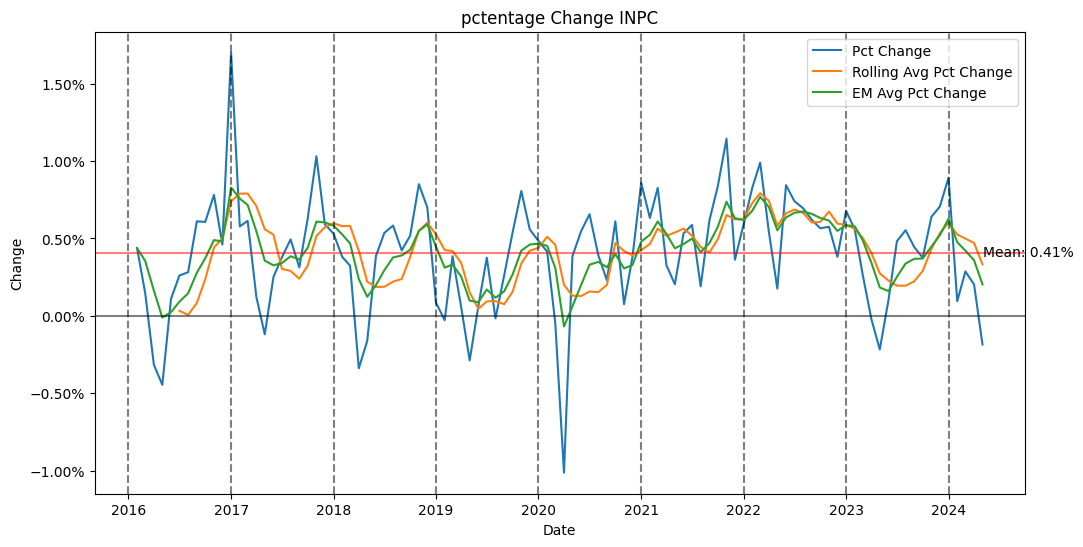

In [6]:
# see trend
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_inpc, x='date', y='pct_change_inpc', label='Pct Change')
sns.lineplot(data=df_inpc, x='date', y='rolling_avg_pct_change_inpc', label='Rolling Avg Pct Change')
sns.lineplot(data=df_inpc, x='date', y='em_avg_pct_change_inpc', label='EM Avg Pct Change')

# add line each year
for year in range(2016, 2025):
    plt.axvline(datetime(year, 1, 1), color='k', linestyle='--', alpha=0.5)

# add hline at 0
plt.axhline(0, color='k', linestyle='-', alpha=0.5)

# add hline at mean
mean_pct_change = df_inpc['pct_change_inpc'].mean()
plt.axhline(mean_pct_change, color='r', linestyle='-', alpha=0.5)
# add text
plt.text(
    df_inpc.index[-1],
    mean_pct_change,
    f'Mean: {mean_pct_change:.2%}',
    verticalalignment='center'
)

# titles
plt.title('pctentage Change INPC')
# labels
plt.xlabel('Date')
plt.ylabel('Change')
# y labels in %
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))


## Save

In [7]:
df_inpc.head(2)

,inpc,pct_change_inpc,rolling_avg_pct_change_inpc,em_avg_pct_change_inpc
date,,,,
2016-01-01,89.386381,NaN,NaN,NaN
2016-02-01,89.777781,0.004379,NaN,0.004379


In [8]:
# save 
dir_save = "../../data/interim/"
(
    df_inpc
    .reset_index()
    .loc[:, ['date', 'inpc', 'pct_change_inpc', 'em_avg_pct_change_inpc']]
    .to_csv(dir_save + 'inpc.csv')
    )

---
# Minimum Wage

## Data

In [9]:
# get data from Banxico
minimum_wage_data = {
    'no_border_north': 'SL11296',
    'general': 'SL11297',

}
banxico_api = SIEBanxico(
    token=os.getenv('API_BANXICO'),
    id_series=list(minimum_wage_data.values()),
    language='en'
)

In [10]:
# see metadata
banxico_api.get_metadata()

{'bmx': {'series': [{'idSerie': 'SL11297',
    'titulo': 'Minimum Wages National Real Index Dec2018=100',
    'fechaInicio': '01/01/1969',
    'fechaFin': '05/01/2024',
    'periodicidad': 'Monthly',
    'cifra': 'Indexes',
    'unidad': 'Without units',
    'versionada': False},
   {'idSerie': 'SL11296',
    'titulo': 'Minimum Wages Northern Border Free Zone Real Index Dec2018=100',
    'fechaInicio': '10/01/2015',
    'fechaFin': '05/01/2024',
    'periodicidad': 'Monthly',
    'cifra': 'Indexes',
    'unidad': 'Without units',
    'versionada': False}]}}

In [11]:
# consult data
today = datetime.today().strftime('%Y-%m-%d')
series_data = banxico_api.get_timeseries_range(
    init_date='2017-01-01',
    end_date=today
)

# append data
dict_df = {}
for serie in series_data['bmx']['series']:
    df_minimum_wage = pd.DataFrame(serie['datos'])
    df_minimum_wage['date'] = pd.to_datetime(df_minimum_wage['fecha'], format='%d/%m/%Y')
    df_minimum_wage.set_index('date', inplace=True)
    df_minimum_wage.drop(columns=['fecha'], inplace=True)
    df_minimum_wage.index = df_minimum_wage.index.strftime('%Y-%m-%d')
    df_minimum_wage = df_minimum_wage.rename(columns={'dato': serie['idSerie']})
    dict_df[serie['idSerie']] = df_minimum_wage

# join dataframes by index
df_minimum_wage = pd.concat(dict_df.values(), axis=1)

# index to DateTimeIndex
df_minimum_wage.index = pd.to_datetime(df_minimum_wage.index)

# dtypes to float
df_minimum_wage = df_minimum_wage.astype(float)

# reset index
df_minimum_wage = df_minimum_wage.reset_index()


# see df
df_minimum_wage

,date,SL11296,SL11297
0,2017-01-01,99.6963,99.6963
1,2017-02-01,99.1235,99.1235
2,2017-03-01,98.5190,98.5190
3,2017-04-01,98.3980,98.3980
4,2017-05-01,98.5158,98.5158
...,...,...,...
84,2024-01-01,327.2725,217.3116
85,2024-02-01,326.9641,217.1068
86,2024-03-01,326.0275,216.4849
87,2024-04-01,325.3698,216.0482


## Wrangling

In [12]:
# wrangle
df_minimum_wage = (
    df_minimum_wage
    .rename(columns={
        'SL11296': 'no_border_north_minimum_wage',
        'SL11297': 'general_minimum_wage'
    })
    .assign(
        # differentiate anually
        pct_change_no_border_north=lambda x: x['no_border_north_minimum_wage'].pct_change(12),
        pct_change_general=lambda x: x['general_minimum_wage'].pct_change(12),
        # exponential moving avg of pct_change of last 6 months
        em_avg_no_border_north=lambda x: x['pct_change_no_border_north'].ewm(span=6, adjust=False).mean(),
        em_avg_general=lambda x: x['pct_change_general'].ewm(span=6, adjust=False).mean()
    )
)

df_minimum_wage

,date,no_border_north_minimum_wage,general_minimum_wage,pct_change_no_border_north,pct_change_general,em_avg_no_border_north,em_avg_general
0,2017-01-01,99.6963,99.6963,NaN,NaN,NaN,NaN
1,2017-02-01,99.1235,99.1235,NaN,NaN,NaN,NaN
2,2017-03-01,98.5190,98.5190,NaN,NaN,NaN,NaN
3,2017-04-01,98.3980,98.3980,NaN,NaN,NaN,NaN
4,2017-05-01,98.5158,98.5158,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
84,2024-01-01,327.2725,217.3116,0.144116,0.144131,0.145538,0.145521
85,2024-02-01,326.9641,217.1068,0.149411,0.149426,0.146644,0.146637
86,2024-03-01,326.0275,216.4849,0.149188,0.149204,0.147371,0.147371
87,2024-04-01,325.3698,216.0482,0.146638,0.146653,0.147162,0.147166


## EDA

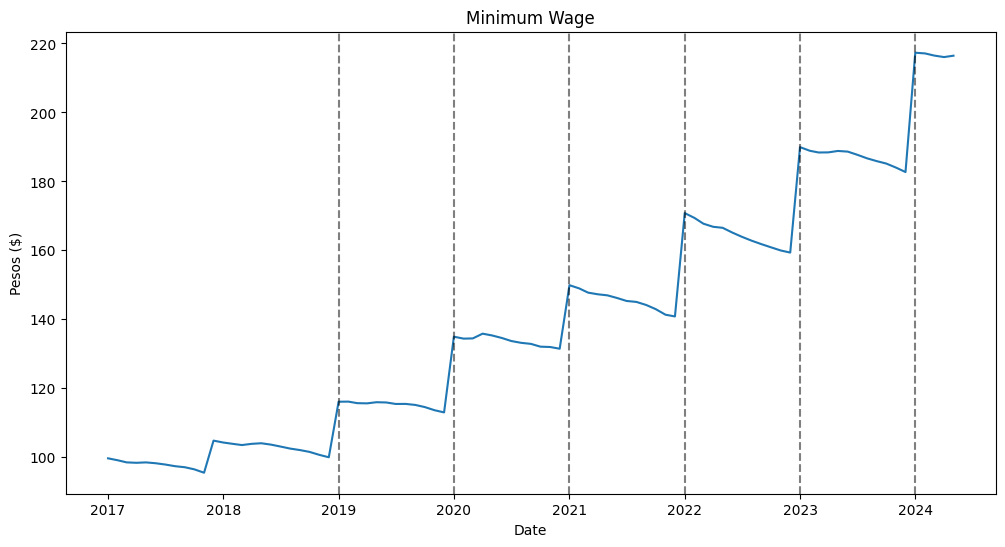

In [13]:
# see trend
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_minimum_wage, x='date', y='general_minimum_wage')

# titles
plt.title('Minimum Wage')
# labels
plt.xlabel('Date')
plt.ylabel('Pesos ($)')
# add line each year
for year in range(2019, 2025):
    plt.axvline(datetime(year, 1, 1), color='k', linestyle='--', alpha=0.5)


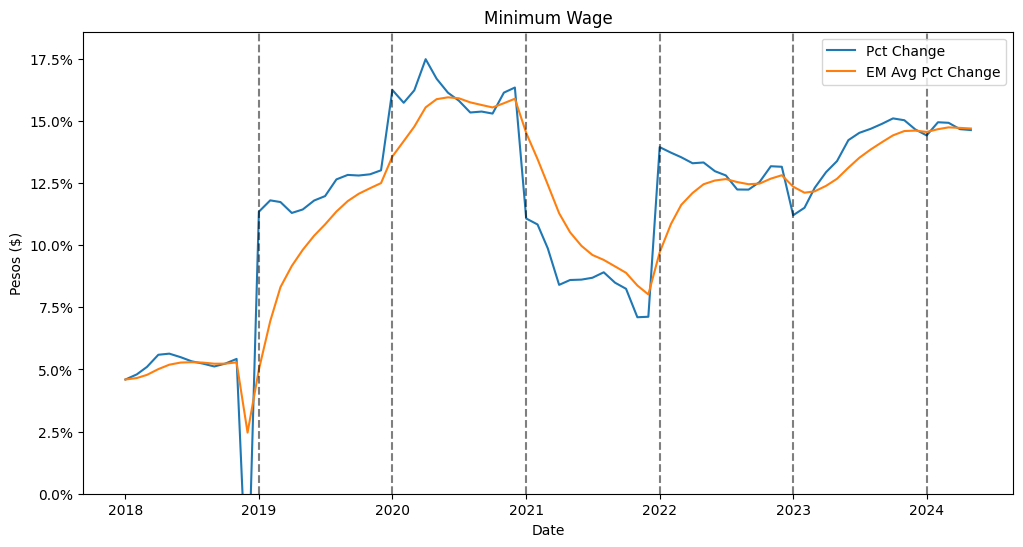

In [14]:
# see trend
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_minimum_wage, x='date', y='pct_change_general', label='Pct Change')
sns.lineplot(data=df_minimum_wage, x='date', y='em_avg_general', label='EM Avg Pct Change')

# titles
plt.title('Minimum Wage')
# labels
plt.xlabel('Date')
plt.ylabel('Pesos ($)')
# add line each year
for year in range(2019, 2025):
    plt.axvline(datetime(year, 1, 1), color='k', linestyle='--', alpha=0.5)

# ylimit 0 to inf
plt.ylim(0, None)

# change y labels to %
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))


## Save

In [15]:
df_minimum_wage.head(2)

,date,no_border_north_minimum_wage,general_minimum_wage,pct_change_no_border_north,pct_change_general,em_avg_no_border_north,em_avg_general
0,2017-01-01,99.6963,99.6963,NaN,NaN,NaN,NaN
1,2017-02-01,99.1235,99.1235,NaN,NaN,NaN,NaN


In [16]:
# save 
dir_save = "../../data/interim/"
(
    df_minimum_wage
    .reset_index()
    .loc[:, ['date', 'general_minimum_wage', 'pct_change_general', 'em_avg_general']]
    .to_csv(dir_save + 'minimum_wage.csv')
    )